## Install Dependenices

In [38]:
!uv venv --python 3.12
!uv pip install tensorflow[and-cuda]
!uv pip install numpy
!uv pip install pandas
!uv pip install matplotlib
!uv pip install tf-models-official

Using CPython 3.12.10
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 1 package in 4ms
Audited 1 package in 1ms
Audited 1 package in 2ms
Audited 1 package in 2ms
Resolved 109 packages in 3.58s                                       
Prepared 58 packages in 11.19s                                           
Uninstalled 2 packages in 128ms
Installed 58 packages in 176ms4.9.8                         
 - absl-py==2.2.2
 + absl-py==1.4.0
 + ai-edge-litert==1.2.0
 + array-record==0.7.1
 + cachetools==5.5.2
 + colorama==0.4.6
 + cython==3.0.12
 + dm-tree==0.1.9
 + docstring-parser==0.16
 + einops==0.8.1
 + etils==1.12.2
 + fsspec==2025.3.2
 + gin-config==0.5.0
 + google-api-core==2.24.2
 + google-api-python-client==2.167.0
 + google-auth==2.39.0
 + google-auth-httplib2==0.2.0
 + googleapis-common-protos==1.70.0
 + httplib2==0.22.0
 + immutabledict==4.2.1
 + importlib-resources==6.5.2
 + joblib==1.4.2
 + kaggle==1.7.4.2
 + lxml==5.3.2
 - numpy==2.1.3
 + nu

## Import Packages

In [41]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
import numpy as np
from tensorflow_models import vision
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'numpy.strings'

## Test if CUDA is Available

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')


## Create dataset from Data Directory

In [4]:
with tf.device('/GPU:0'):
    tr_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '../data_directory',
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(256,256),
        seed=0,
        validation_split=0.2,
        subset='training',
        interpolation='bilinear'  
    )
    
    vl_ds = tf.keras.preprocessing.image_dataset_from_directory(
        '../data_directory',
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        seed=0,
        image_size=(256,256),
        validation_split=0.2,
        subset='training',
        interpolation='bilinear'  
    )

I0000 00:00:1745236978.704910    1785 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 2707 files belonging to 6 classes.
Using 2166 files for training.
Found 2707 files belonging to 6 classes.
Using 2166 files for training.


## Data Visualization

2025-04-21 20:03:01.161457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


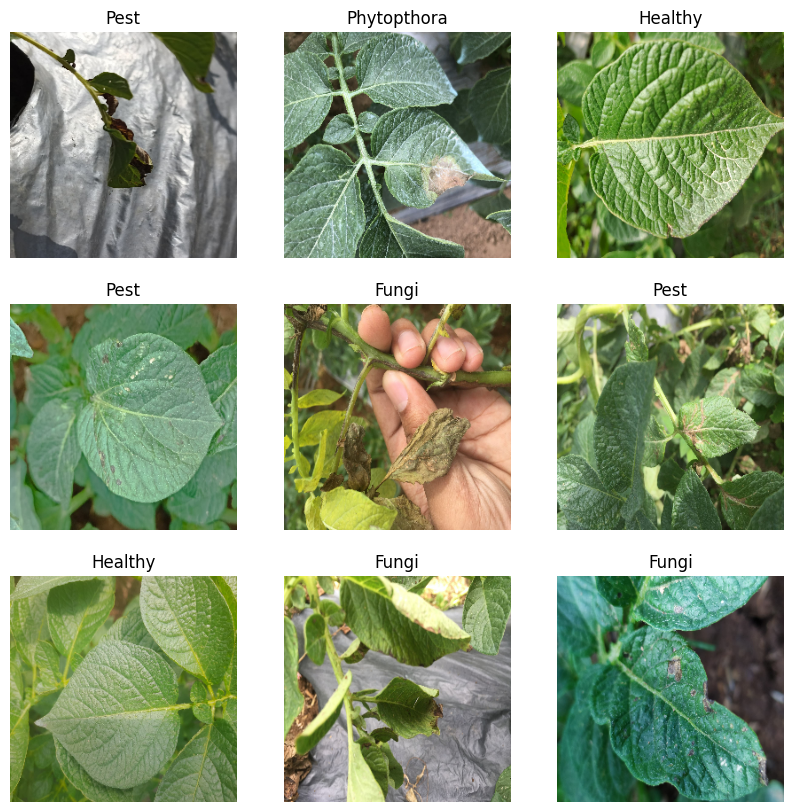

In [5]:
with tf.device('/GPU:0'):
    class_names = tr_ds.class_names
    plt.figure(figsize=(10,10))
    for images, labels in tr_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

## Data Preprocessing

### Preprocessing Functions

In [98]:
# ty chatgpt eme
def sharpen_image(image):
    """
    Sharpen the image by applying a convolution with a sharpening kernel.
    Args:
        image: Tensor of shape [batch_size, height, width, channels]
    Returns:
        sharpened: Tensor of the same shape after applying sharpening
    """

    # Define a sharpening kernel (3x3)
    sharpening_kernel = tf.constant([
        [[[-1.0]], [[-1.0]], [[-1.0]]],
        [[[-1.0]], [[5.0]],  [[-1.0]]],
        [[[-1.0]], [[-1.0]], [[-1.0]]]
    ], dtype=tf.float32)  # Shape: [3, 3, 1, 1]

    # Repeat the kernel for each channel in the image
    channels = image.shape[-1]  # Get the number of channels
    sharpening_kernel = tf.repeat(sharpening_kernel, channels, axis=2)  # Shape: [3, 3, C, 1]

    # Apply depthwise convolution (one kernel per channel)
    sharpened = tf.nn.depthwise_conv2d(image, sharpening_kernel, strides=[1, 1, 1, 1], padding='SAME')

    # Clip values to [0, 1] to ensure valid pixel range
    sharpened = tf.clip_by_value(sharpened, 0.0, 1.0)

    return sharpened
def preprocessing_pipeline(image, label):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    image = normalization_layer(image)
    image = sharpen_image(image)
    return image, label

### Preprocessing Step

In [99]:
with tf.device('/GPU:0'):
    processed_ds = tr_ds.map(preprocessing_pipeline)
    image_batch, labels_batch = next(iter(processed_ds))
    first_image = image_batch[0]
    # Notice the pixel values are now in `[0,1]`.
    print(np.min(first_image), np.max(first_image))

0.0 1.0


### Show Preprocessed Data

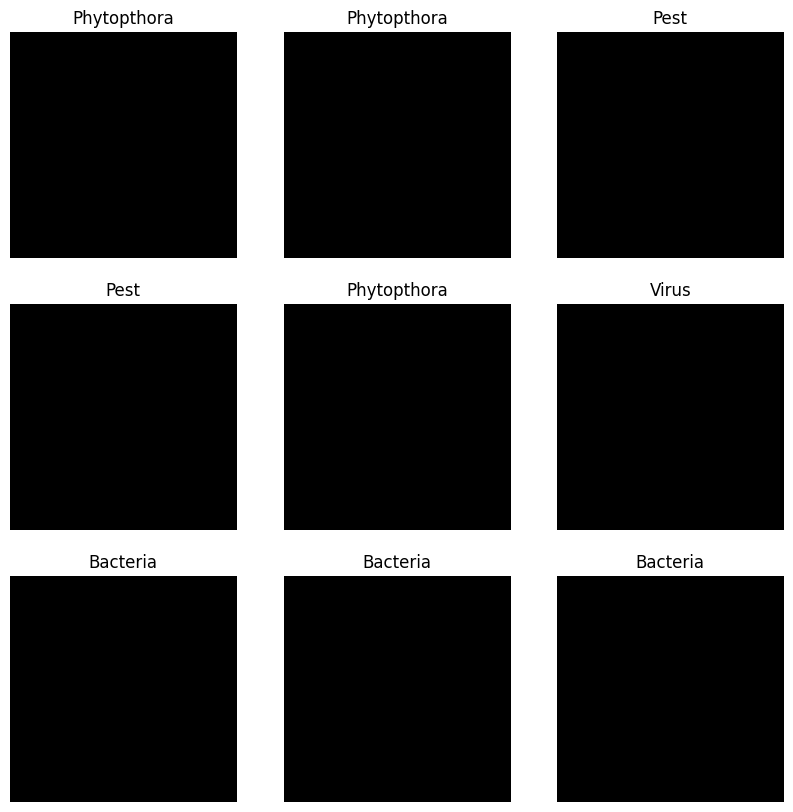

In [100]:
with tf.device('/GPU:0'):
    class_names = tr_ds.class_names
    plt.figure(figsize=(10,10))
    for images, labels in processed_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

## Model Kineme


In [101]:
with tf.device('/GPU:0'):
    num_classes = len(class_names)
    print(num_classes)
    model = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(256, 256, 3)),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

6


/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
with tf.device('/GPU:0'):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    model.summary()
    

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_30 (Rescaling)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,871,366 (64.36 MB)

 Trainable params: 16,871,366 (64.36 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
with tf.device('/CPU:0'):
    epochs=10
    history = model.fit(
      processed_ds,
      validation_data=vl_ds,
      epochs=epochs
    )


Epoch 1/10


2025-04-21 20:46:56.614124: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at xla_ops.cc:529 : INVALID_ARGUMENT: Trying to access resource sequential_1/conv2d_3/kernel/92 (defined @ /home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py:39) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
2025-04-21 20:46:56.614247: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Trying to access resource sequential_1/conv2d_3/kernel/92 (defined @ /home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py:39) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.

InvalidArgumentError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/dyden/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/dyden/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/dyden/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_1785/2466052329.py", line 3, in <module>

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Trying to access resource sequential_1/conv2d_3/kernel/92 (defined @ /home/dyden/.cache/uv/archive-v0/at7H4Xnvx27LksSs7Yxs5/lib/python3.12/site-packages/keras/src/backend/tensorflow/core.py:39) located in device /job:localhost/replica:0/task:0/device:GPU:0 from device /job:localhost/replica:0/task:0/device:CPU:0
 Cf. https://www.tensorflow.org/xla/known_issues#tfvariable_on_a_different_device
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_7539]

## Results

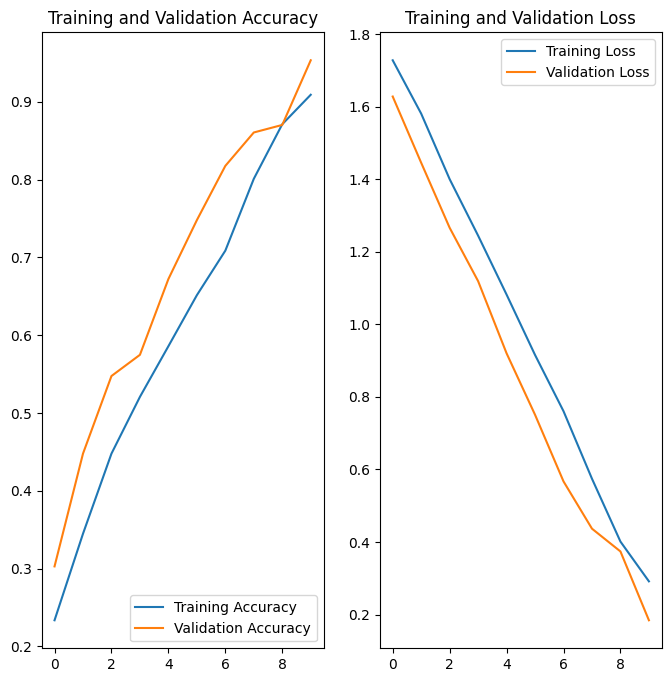

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()